In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from synphot import SpectralElement
from synphot.models import Empirical1D

import os
gd_folder = os.getcwd()+"/../../Calculations/Gas_and_dust/"

import sys 
sys.path.append(gd_folder)
from polWaveDust import PolWaveDust
from polWaveGas import PolWaveGas

In [2]:
#Find the redshift of each object. 
z = dict()
d20 = open("../SED_models/double.20")
d22 = open("../SED_models/double.22")
for line in d20:
    x = line.split()
    y = d22.readline().split()
    z[y[-1]] = float(x[1])
d20.close()
d22.close()

In [3]:
#Load the bands with synphot. 
filt_files = {
    "R_SPECIAL":"M_SPECIAL_R.txt",
    "I_BESS": "M_BESS_I.txt",
    "v_HIGH": "v_HIGH.txt"
}
bp = dict()
for key in filt_files:
    skiprows=0
    if key=="v_HIGH":
        skiprows=2
    data = np.loadtxt("../../Filter_Curves/{}".format(filt_files[key]),skiprows=skiprows)
    wave = data[:,0]*10
    thru = data[:,1]
    bp[key] = SpectralElement(Empirical1D, points=wave[wave<10000.], lookup_table=thru[wave<10000.], keep_neg=True)
    print(key, bp[key].barlam(), bp[key].fwhm(), bp[key].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7908.260159757317 Angstrom 1335.7995225325858 Angstrom 1434.877194229439 Angstrom
v_HIGH 5531.766519253978 Angstrom 849.8588260783428 Angstrom 1195.1036753366664 Angstrom


In [4]:
objects = {"W0019-1046","W0204-0506","W0220+0137","W0831+0140","W0116-0505"}
filters = dict()
for obj in objects:
    filters[obj] = ["R_SPECIAL"]
filters["W0116-0505"].extend(["I_BESS","v_HIGH"])

In [5]:
#Read the polarization fraction values. 
pfrac = dict()
epfrac = dict()
for obj in objects:
    pfrac[obj] = dict()
    epfrac[obj] = dict()
    for filt in filters[obj]:
        data = np.genfromtxt("../../analysis_v3/{}_pol_{}.dat".format(obj,filt), usecols=[0,1,7], dtype=[('pfrac', '<f8'), ('epfrac','<f8'),('OBID','<U10')])
        if len(data.shape)>0:
            k = np.argwhere(data['OBID']=="All")[0][0]
            pfrac[obj][filt] = data['pfrac'][k]
            epfrac[obj][filt] = data['epfrac'][k]
        else:
            pfrac[obj][filt] = data['pfrac']
            epfrac[obj][filt] = data['epfrac']

In [6]:
# # p_meas = 0.1109
# # p_err = 0.0023
# # lam_targ = 6501*u.AA/(1+3.173)
# # p_meas = 0.1430
# # p_err = 0.0045
# # lam_targ = 7908*u.AA/(1+3.173)
# p_meas = 0.0959
# p_err = 0.0040
# lam_targ = 5532*u.AA/(1+3.173)

# wid = "W0116-0505"
# band = "R_SPECIAL"
# p_meas = pfrac[wid][band]
# p_err = epfrac[wid][band]
# lam_targ = bp[band].barlam()/(1+z[wid])
# pw = PolWaveDust("SMC")
# psi_grid   = np.arange(pw.psi_grid.min().value  , pw.psi_grid.max().value  , 0.5)*u.deg
# theta_grid = np.arange(pw.theta_grid.min().value, pw.theta_grid.max().value, 0.5)*u.deg
# p_map = np.ma.zeros((len(theta_grid), len(psi_grid)))
# p_map.mask = np.zeros(p_map.shape, dtype=bool)
# for i, th in enumerate(theta_grid):
#     for j, psi in enumerate(psi_grid):
#         if th<psi:
#             p_map[i,j] = np.nan
#             p_map.mask[i,j] = True
#         else:
#             p_map[i,j] = pw.p((lam_targ, th, psi))
# chi2_map = ((p_map-p_meas)/p_err)**2

In [7]:
# chi2_map2 = get_chi2_map(p_meas, p_err, lam_targ, pw)

In [8]:
# print(chi2_map)
# print()
# print(chi2_map2)

In [21]:
# p_meas = 0.1109
# p_err = 0.0023
# lam_targ = 6501*u.AA/(1+3.173)
# p_meas = 0.1430
# p_err = 0.0045
# lam_targ = 7908*u.AA/(1+3.173)
# p_meas = 0.0959
# p_err = 0.0040
# lam_targ = 5532*u.AA/(1+3.173)

def get_p_chi2_map(p_meas, p_err, lam_targ, pw):

    #Set the grid of values for the calculation. 
    psi_grid   = np.arange(pw.psi_grid.min().value  , pw.psi_grid.max().value  , 0.5)*u.deg
    theta_grid = np.arange(pw.theta_grid.min().value, pw.theta_grid.max().value, 0.5)*u.deg
    psi_2d_grid, th_2d_grid = np.meshgrid(psi_grid, theta_grid)
    lam_2d_grid = lam_targ * np.ones(psi_2d_grid.shape)

    #Calculate the interpolated polarization map. 
    p_map = np.ma.zeros((len(theta_grid), len(psi_grid)))
    p_map.mask = np.zeros(p_map.shape, dtype=bool)
    p_map[:,:] = pw.p((lam_2d_grid, th_2d_grid, psi_2d_grid))

    #Turn into percentages. 
    p_map *= 100
    
    #Remove angles were we would directly see the accretion disk. 
    p_map[th_2d_grid<psi_2d_grid] = np.nan
    p_map.mask[th_2d_grid<psi_2d_grid] = True

    #Transform it into a chi-squared map
    chi2_map = ((p_map-p_meas)/p_err)**2

    return p_map, chi2_map


In [22]:
dust_types = ["SMC","LMC","MW"]
p_map = dict()
chi2_map = dict()
for dust_type in dust_types:
    p_map[dust_type] = dict()
    chi2_map[dust_type] = dict()
    pw = PolWaveDust(dust_type, interp_method='linear')
    for wid in pfrac.keys():
        p_map[dust_type][wid] = dict()
        chi2_map[dust_type][wid] = dict()
        for band in pfrac[wid].keys():
            lam_targ = bp[band].barlam()/(1+z[wid])
            p_map[dust_type][wid][band], chi2_map[dust_type][wid][band] = get_p_chi2_map(pfrac[wid][band], epfrac[wid][band], lam_targ, pw)

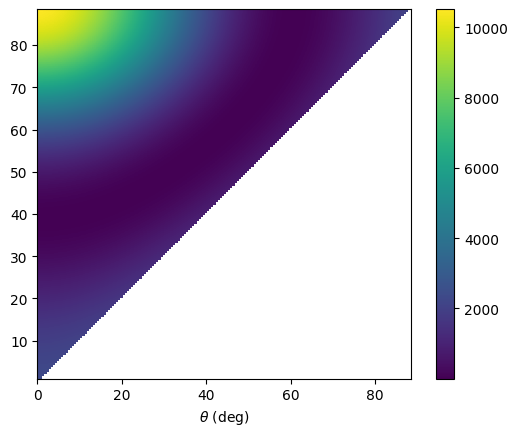

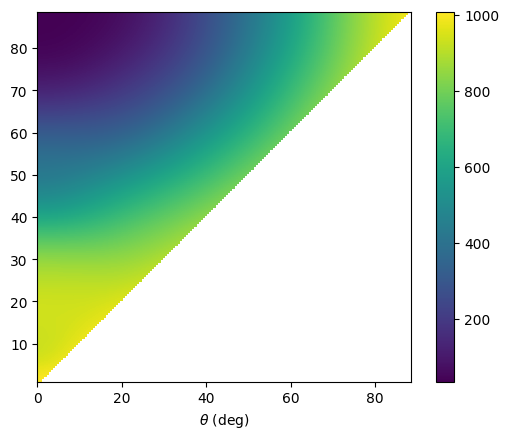

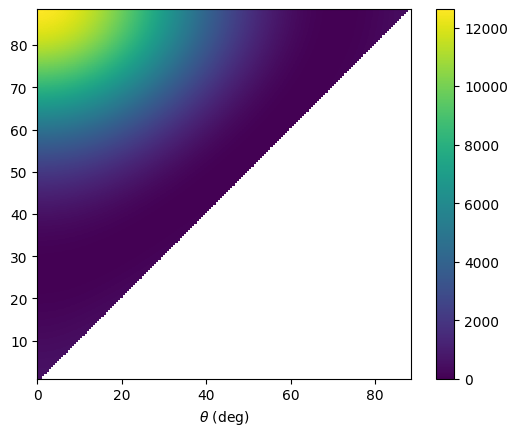

In [23]:
wid = "W0116-0505"
dust_type = "SMC"
pw = PolWaveDust(dust_type)
for band in pfrac[wid].keys():
    fig, ax = plt.subplots(1)
    x0 = pw.psi_grid[0].value
    x1 = pw.psi_grid[-1].value
    y0 = pw.theta_grid[0].value
    y1 = pw.theta_grid[-1].value
    cm = ax.imshow(chi2_map[dust_type][wid][band], origin='lower', extent=[x0,x1,y0,y1])
    ax.set_xlabel(r'$\psi~(\rm deg)$')
    ax.set_xlabel(r'$\theta~(\rm deg)$')
    fig.colorbar(cm)
    plt.show()

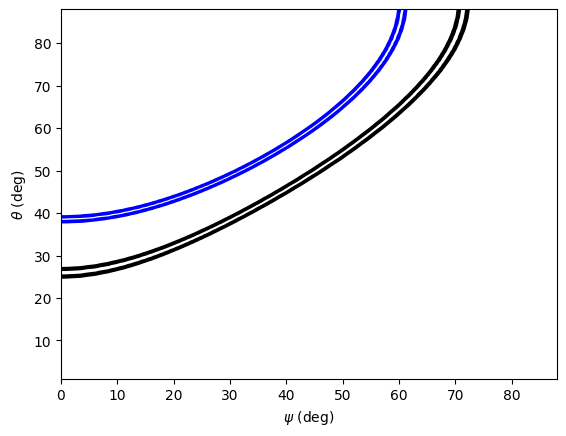

In [24]:
fig, ax = plt.subplots(1)

psi_grid   = np.arange(pw.psi_grid.min().value  , pw.psi_grid.max().value  , 0.5)*u.deg
theta_grid = np.arange(pw.theta_grid.min().value, pw.theta_grid.max().value, 0.5)*u.deg
wid = "W0116-0505"
dust_type = "SMC"
colors = ["blue", "red", "black"]
for j, band in enumerate(pfrac[wid].keys()):
    ax.contour(psi_grid, theta_grid, chi2_map[dust_type][wid][band], levels=[1., 2., 3.], colors=colors[j])
           
ax.set_xlabel(r'$\psi~(\rm deg)$')
ax.set_ylabel(r'$\theta~(\rm deg)$')

plt.show()

In [ ]:
ths  = np.arange(0., 90.1, 2.5)
psis = np.arange(0., 90.1, 2.5)

Norm = mpl.colors.Normalize(vmin=ths[0], vmax=ths[-1])
cmap = mpl.cm.jet

fig, axs = plt.subplots(2, 2, figsize=(24,16))
for th in ths:
    c = cmap(Norm(th))
    p_aux = pw.p((lam_targ*np.ones(len(psis)), th*np.ones(len(psis)), psis))
    axs[0,1].plot(psis, p_aux, color=c, ls='solid')